# System Setup

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
import nglview as nv
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from functions import *

In [3]:
## The Atomic Radii used for SASA calculation
_ATOMIC_RADII = {'H'   : 0.120, 'He'  : 0.140, 'Li'  : 0.076, 'Be' : 0.059,
                 'B'   : 0.192, 'C'   : 0.170, 'N'   : 0.155, 'O'  : 0.152,
                 'F'   : 0.147, 'Ne'  : 0.154, 'Na'  : 0.102, 'Mg' : 0.086,
                 'Al'  : 0.184, 'Si'  : 0.210, 'P'   : 0.180, 'S'  : 0.180,
                'Ca'   : 0.200, 'Cl'  : 0.200, 'Zn'  : 0.200, 'VS' : 0.152,
                 'I'   : 0.220, 'Br'  : 0.196 , 'A'  : 0.170,}

# Pocket Analysis

## Read Proteins and  Calculate SASA

In [4]:
# Path to output files from FPocket Pocket Hunt
path2out = 'hmx.B99990001_out/hmx.B99990001_out.pdb'
path2config = '../03_docking_prep/config'
# Load the file with mdtraj and convert to table
pdb = md.load(path2out)
table, _ = pdb.topology.to_dataframe()

# from the table get the atom indices, coords and elements for both proteins
A_ids = table.query('chainID == 0').index
B_ids = table.query('chainID == 1').index
A_xyz = pdb.xyz[:,A_ids]
B_xyz = pdb.xyz[:,B_ids]
A_elems = table.loc[A_ids,'element'].values
B_elems = table.loc[B_ids,'element'].values

# SASA calculation with external function 
### would be better if we wrote functions.Sasa_calc, then its clear where the function comes from
A_Radii    = [_ATOMIC_RADII[element] for element in A_elems]
B_Radii    = [_ATOMIC_RADII[element] for element in B_elems]  
A_SASA     = Sasa_calc(A_xyz,A_Radii)[0]
B_SASA     = Sasa_calc(B_xyz,B_Radii)[0]

## Read Pocket and Calculate BSA

In [5]:
# create subtable just for all the pockets
P_table = table.query('chainID == 2')
P_count = P_table.resSeq.max()
P_boxv = np.zeros([P_count,3])
P_com = np.zeros([P_count,3])

# initialise arrays for SASA calculation aswell as Drug Score and Pocket Score
P_SASA = np.zeros(P_count)
AP_SASA = np.zeros_like(P_SASA)
BP_SASA = np.zeros_like(P_SASA)
S_Pocket = np.zeros_like(P_SASA)
S_Drug = np.zeros_like(P_SASA)

# define file path to the different pqr files from Pocket hunt
P_pqr = 'hmx.B99990001_out/pockets/pocket{}_vert.pqr'

# iterate over the different pockets which are identified by resSeq column in the Pocket Table
for i, pocket in enumerate(P_table.groupby('resSeq')):
    
    # get correct file name for the corresponding pocket
    path2pqr = P_pqr.format(i+1)
    
    # define Pocket ids, positions and Radii from the pocket (groupby() yields the [0]:groupID and [1]:group itself)
    P_ids = pocket[1].index
    P_xyz = pdb.xyz[:,P_ids]
    P_Radii = [0.152]*len(P_ids)
    
    # Sasa calculation and Scoring with functions from functions.py based on Properties from A, B and P! 
    P_com[i], P_boxv[i] = pocket2boxsize(P_xyz)
    P_SASA[i] = Sasa_calc(P_xyz, P_Radii)[0]
    AP_SASA[i] = Sasa_calc(np.concatenate([A_xyz, P_xyz],axis=1),A_Radii + P_Radii)[0]
    BP_SASA[i] = Sasa_calc(np.concatenate([B_xyz, P_xyz],axis=1),B_Radii + P_Radii)[0]
    S_Pocket[i], S_Drug[i] = read_output(path2pqr,pocket_pattern)

In [6]:
# define data and columns for proper Pocket data table
P_data = np.array([P_SASA,AP_SASA,BP_SASA,S_Drug,S_Pocket]).T
P_cols = ['SASA_P','SASA_AP','SASA_BP','D_Score','P_Score']

# Create Data table and calculate additional properties important for identification of good pockets
df_P = pd.DataFrame(P_data, columns=P_cols)
df_P['Pocket'] = np.arange(P_count)+1
df_P['BSA_AP'] = P_SASA + A_SASA - AP_SASA
df_P['BSA_BP'] = P_SASA + B_SASA - BP_SASA
df_P['BSA_min'] = df_P[['BSA_AP','BSA_BP']].values.min(axis=1)

In [7]:
# Include geometrical information in the data table
margin_size = 5 
grid_size=0.375
df_P['com_x'],df_P['com_y'],df_P['com_z'] = P_com.T
df_P['box_x'],df_P['box_y'],df_P['box_z'] = (P_boxv.T+margin_size)/grid_size

In [8]:
# Print the first few pockets with good Buried Surface Area values
df_P.query('BSA_min > 20')

,SASA_P,SASA_AP,SASA_BP,D_Score,P_Score,Pocket,BSA_AP,BSA_BP,BSA_min,com_x,com_y,com_z,box_x,box_y,box_z
1,638.000000,19256.900391,12334.500000,0.0095,0.2199,2,94.599609,795.699219,94.599609,13.800000,42.369999,60.090000,50.186666,49.306666,25.493333
7,399.000000,19018.599609,12476.200195,0.0003,0.0990,8,93.900391,414.999023,93.900391,35.599998,40.660000,57.520000,28.053333,38.053335,24.800001
8,225.600006,18785.400391,12468.399414,0.0040,0.0766,9,153.699615,249.399811,153.699615,34.330002,21.620001,71.980003,21.626666,21.840000,19.013334
9,334.000000,18718.599609,12801.700195,0.0011,0.0747,10,328.900391,24.499023,24.499023,11.520000,27.469999,74.440002,25.893333,27.866666,24.826667
10,625.500000,18641.701172,12889.300781,0.0001,0.0610,11,697.298828,228.398438,228.398438,26.290001,28.219999,47.400002,46.453334,32.586666,35.120000
16,811.099976,18498.699219,12985.899414,0.0089,0.0398,17,1025.900757,317.399780,317.399780,31.180000,24.240000,65.519997,43.306666,44.133334,44.160001
23,224.799988,18871.500000,12466.200195,0.0006,-0.0061,24,66.799988,250.799011,66.799988,35.299999,34.419998,63.680000,23.893333,23.413333,17.466667
24,233.000000,18723.199219,12688.600586,0.0001,-0.0186,25,223.300781,36.598633,36.598633,17.740000,31.879999,56.450001,17.546667,23.493333,22.240000
34,282.299988,18767.099609,12638.099609,0.0003,-0.1182,35,228.700378,136.399597,136.399597,5.320000,32.650002,71.029999,20.213333,19.893333,29.626667


## Data Visualization

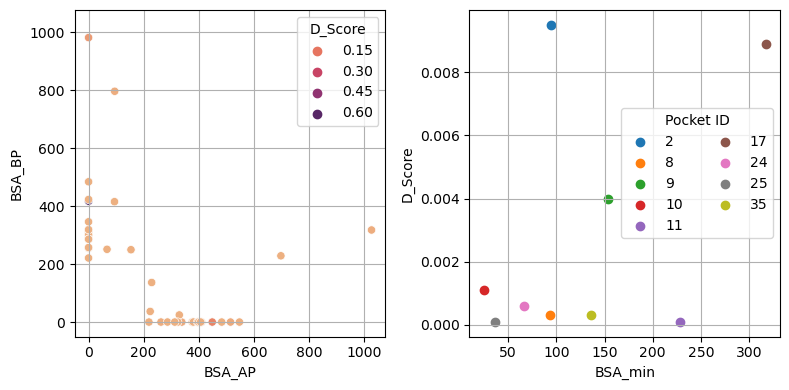

In [9]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
plot_BSA_Score(df_P, 
               xcol='BSA_AP',
               ycol='BSA_BP',
               min_col='BSA_min',
               score='D_Score', 
               plot_margin = 50,
               axs = axs,
               legend = 'Pocket ID')

plt.savefig('pocket_sasa_drugscore.jpeg')

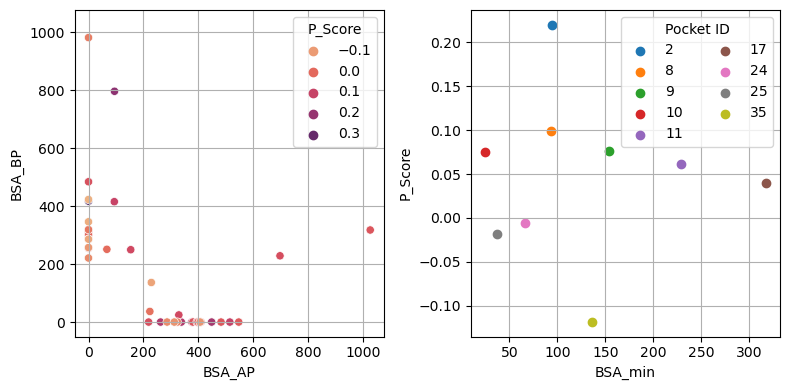

In [10]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
plot_BSA_Score(df_P,
               xcol='BSA_AP',
               ycol='BSA_BP',
               min_col='BSA_min',
               score='P_Score',
               plot_margin=50,
               axs=axs,
               legend='Pocket ID')

plt.savefig('pocket_sasa_pocketscore.jpeg')

## Structure Visualization

In [14]:
# Visualise Structure, change the P_id value to the most promising pocket candidate (or any other candidate for that matter)
P_id = 17
print(df_P.query('Pocket==@P_id')[['Pocket','com_x','com_y','com_z','box_x','box_y','box_z']])
view = nv.show_mdtraj(pdb)
pocket_visualize(view,pocket_id=P_id)
view

    Pocket  com_x  com_y      com_z      box_x      box_y      box_z
16      17  31.18  24.24  65.519997  43.306666  44.133334  44.160001


NGLWidget()

In [12]:
# Save the Box dimensions of the Pocket with P_id in config file for docking in later steps

_, x, y, z, vx, vy, vz = df_P.query('Pocket==@P_id')[['Pocket',
                                                'com_x',
                                                'com_y',
                                                'com_z',
                                                'box_x',
                                                'box_y',
                                                'box_z']].values[0]

with open(path2config, 'w') as f:
    f.write('center_x = {:2.2f}\n'.format(x))
    f.write('center_y = {:2.2f}\n'.format(y))
    f.write('center_z = {:2.2f}\n'.format(z))
    f.write('size_x = {:2.2f}\n'.format(vx))
    f.write('size_y = {:2.2f}\n'.format(vy))
    f.write('size_z = {:2.2f}\n'.format(vz))

In [15]:
# Visualise Structure, change the P_id value to second most promising pocket candidate
P_id = 9
print(df_P[df_P['Pocket']==P_id][['Pocket','com_x','com_y','com_z','box_x','box_y','box_z']])
view = nv.show_mdtraj(pdb)
pocket_visualize(view,pocket_id=P_id)
view

   Pocket      com_x      com_y      com_z      box_x  box_y      box_z
8       9  34.330002  21.620001  71.980003  21.626666  21.84  19.013334


NGLWidget()